In [69]:
import seml
import pandas as pd
import glob
import mudata as mu
import deconvatac as de
import seaborn as sns
import tqdm

In [70]:
def get_proportions(adata):
    df = pd.DataFrame(adata.obsm["proportions"], columns=adata.uns["proportion_names"], index=adata.obs_names)
    return df

In [98]:
tables = ['tangram', 'rctd', 'spatialdwls', 'destvi'] # cell2location, moscot 

In [99]:
df = [seml.get_results(table, to_data_frame=True) for table in tables]

100%|██████████| 23/23 [00:00<00:00, 10145.02it/s]


In [100]:
df = pd.concat(df)

In [101]:
df.to_csv('results_table.csv')

In [85]:
# tangram
# columns: cell type, values not proportions --> normalization

# cell2location
# columns: meanscell_abundance_w_sf_ cell type, values not proportions --> normalization

# destvi
# columns: cell type, values are proportions 

# rctd
# columns: cell type, values are proportions

# spatialdwls
# columns: cell type, values are proportions

In [88]:
# load table
# load ground truth
# clean cell type names
# sort cell types
# normalize if necessary
# compute metrics
# record metric, config

In [89]:
def load_table(path, method):
    res = pd.read_csv(row["result.result_path"], index_col=0)
    if "q05cell_abundance_w_sf_" in res.columns:
        res.columns = res.columns.to_series().str.split("q05cell_abundance_w_sf_", expand=True).loc[:, 1].values
    elif "meanscell_abundance_w_sf_" in res.columns:
        res.columns = res.columns.to_series().str.split("meanscell_abundance_w_sf_", expand=True).loc[:, 1].values
    if res.index[0] != 0:
        res.index = res.index.astype(int) - 1
    res.index = res.index.astype(str)
    res = res.div(res.sum(axis=1), axis=0)
    return res

In [90]:
jsd = []
rmse = []
for i, row in tqdm.tqdm(df.iterrows()):
    # load ground truth
    target_adata = mu.read(row["config.data.mdata_spatial_path"])
    targets = get_proportions(target_adata[row["config.data.modality"]])

    # load table
    predictions = load_table(row["result.result_path"], row["config.method.method_id"])
    predictions = predictions.loc[targets.index, targets.columns]

    jsd.append(de.tl.jsd(predictions, targets))
    rmse.append(de.tl.rmse(predictions, targets))
df["jsd"] = jsd
df["rmse"] = rmse

52it [03:37,  4.18s/it]


In [91]:
df.head()

,_id,config.overwrite,config.db_collection,config.data.labels_key,config.data.mdata_reference_path,config.data.mdata_spatial_path,config.data.modality,config.data.var_HVF_column,config.method.method_id,config.model.output_path,...,result.result_path,result.dataset,result.modality,result.var_HVF_column,config.model.r_lib_path,config.data.cluster_column,config.data.layer,config.model.n_cell,jsd,rmse
0,1,1,tangram,cell_type,/vol/storage/data/cellxgene/human_cardiac_nich...,/vol/storage/data/simulations/Heart_1.h5mu,atac,highly_variable,Tangram,/vol/storage/data/deconvolution_results/tangram/,...,/vol/storage/data/deconvolution_results/tangra...,Heart_1,atac,highly_variable,NaN,NaN,NaN,NaN,0.925091,0.228976
1,2,2,tangram,cell_type,/vol/storage/data/cellxgene/human_cardiac_nich...,/vol/storage/data/simulations/Heart_1.h5mu,atac,highly_accessible,Tangram,/vol/storage/data/deconvolution_results/tangram/,...,/vol/storage/data/deconvolution_results/tangra...,Heart_1,atac,highly_accessible,NaN,NaN,NaN,NaN,0.926100,0.229473
2,3,3,tangram,cell_type,/vol/storage/data/cellxgene/human_cardiac_nich...,/vol/storage/data/simulations/Heart_2.h5mu,atac,highly_variable,Tangram,/vol/storage/data/deconvolution_results/tangram/,...,/vol/storage/data/deconvolution_results/tangra...,Heart_2,atac,highly_variable,NaN,NaN,NaN,NaN,0.597795,0.117293
3,4,4,tangram,cell_type,/vol/storage/data/cellxgene/human_cardiac_nich...,/vol/storage/data/simulations/Heart_2.h5mu,atac,highly_accessible,Tangram,/vol/storage/data/deconvolution_results/tangram/,...,/vol/storage/data/deconvolution_results/tangra...,Heart_2,atac,highly_accessible,NaN,NaN,NaN,NaN,0.603186,0.119302
4,5,5,tangram,cell_type,/vol/storage/data/cellxgene/human_cardiac_nich...,/vol/storage/data/simulations/Heart_3.h5mu,atac,highly_variable,Tangram,/vol/storage/data/deconvolution_results/tangram/,...,/vol/storage/data/deconvolution_results/tangra...,Heart_3,atac,highly_variable,NaN,NaN,NaN,NaN,0.628832,0.139311


In [97]:
df['config.method.method_id'].value_counts()

config.method.method_id
DestVI         23
Tangram        20
SpatialDWLS     6
RCTD            3
Name: count, dtype: int64

<Axes: xlabel='config.method.method_id', ylabel='jsd'>

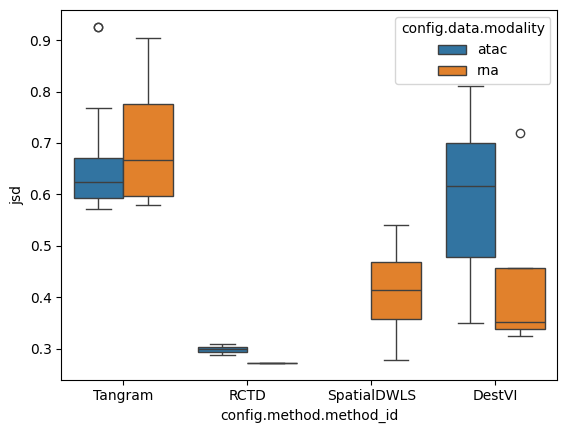

In [96]:
sns.boxplot(data=df.reset_index(), x="config.method.method_id", y="jsd", hue="config.data.modality")

<Axes: xlabel='config.method.method_id', ylabel='rmse'>

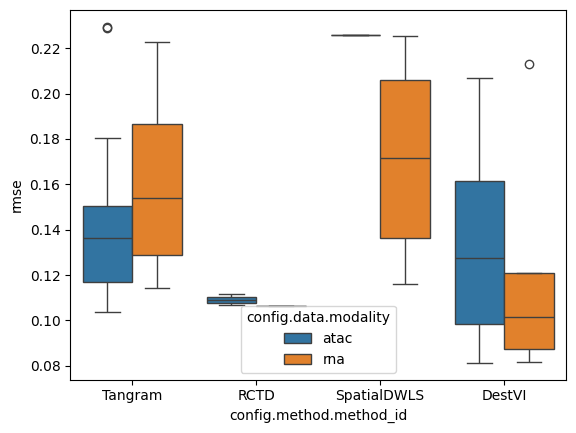

In [95]:
sns.boxplot(data=df.reset_index(), x="config.method.method_id", y="rmse", hue='config.data.modality')